<a href="https://colab.research.google.com/github/Jiyong-Jeon/GAN_study/blob/main/Gan_%EC%B2%AB%EA%B1%B8%EC%9D%8C/%EC%96%BC%EA%B5%B4_%EC%9D%B4%EB%AF%B8%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# error
# import torchvision.datasets

# # download data

# mnist_dataset = torchvision.datasets.CelebA(root='.', download=True)

RuntimeError: ignored

### Celeba 데이터셋 다운로드
- [데이터셋 사이트](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
- [한빛출판사](https://www.hanbit.co.kr/support/supplement_survey.html?pcode=B9417661237)

In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


### HDF5 로 변환

In [2]:
import h5py
import zipfile
import imageio
import os

In [10]:
%%time

# location of the HDF5 package, yours may be under /gan/ not /myo_gan/
hdf5_file = 'mount/MyDrive/CelebA/celeba_aligned_small.h5py'

# how many of the 202,599 images to extract and package into HDF5
total_images = 20000

with h5py.File(hdf5_file, 'w') as hf:

    count = 0

    with zipfile.ZipFile('mount/MyDrive/CelebA/img_align_celeba.zip', 'r') as zf:
      for i in zf.namelist():
        if (i[-4:] == '.jpg'):
          # extract image
          ofile = zf.extract(i)
          img = imageio.imread(ofile)
          os.remove(ofile)

          # add image data to HDF5 file with new name
          hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)

          count = count + 1
          if (count%1000 == 0):
            print("images done .. ", count)

          # stop when total_images reached
          if (count == total_images):
            break

<timed exec>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


images done ..  1000
images done ..  2000
images done ..  3000
images done ..  4000
images done ..  5000
images done ..  6000
images done ..  7000
images done ..  8000
images done ..  9000
images done ..  10000
images done ..  11000
images done ..  12000
images done ..  13000
images done ..  14000
images done ..  15000
images done ..  16000
images done ..  17000
images done ..  18000
images done ..  19000
images done ..  20000
CPU times: user 3min 43s, sys: 14.2 s, total: 3min 57s
Wall time: 4min 58s


### celebA GAN

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

In [4]:
# check CUDA
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

In [5]:
with h5py.File('mount/MyDrive/CelebA/celeba_aligned_small.h5py', 'r') as file_object:
  for group in file_object:
    print(group)

img_align_celeba


(218, 178, 3)

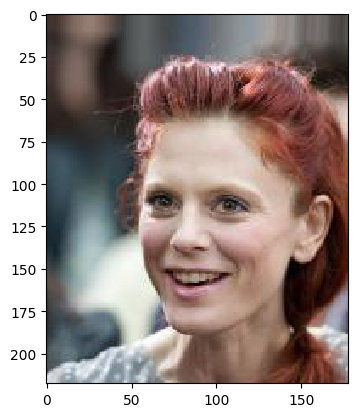

In [6]:
import numpy
import matplotlib.pyplot as plt

with h5py.File('mount/MyDrive/CelebA/celeba_aligned_small.h5py', 'r') as file_object:
  dataset = file_object['img_align_celeba']
  image = numpy.array(dataset['1.jpg'])
  plt.imshow(image, interpolation='none')
image.shape

### Dataset

In [7]:
class CelebADataset(Dataset):

    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if (index >= len(self.dataset)):  # HDF5에서는 인덱스의 범위가 벗어나면 pytorch가 기대하는 indexError가 아닌 오류를 하기 발생
          raise IndexError()              # 미리 형태를 확인하는 습관
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        return torch.cuda.FloatTensor(img) / 255.0  # Cuda 텐서로 변환하여 반환

    def plot_image(self, index): # 출력
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')

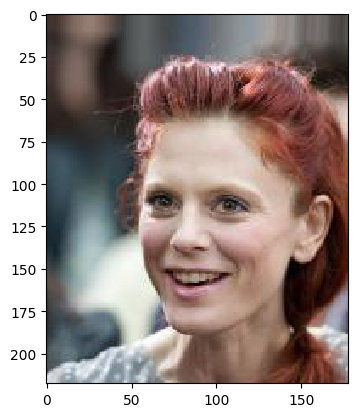

In [9]:
celeba_dataset = CelebADataset('mount/MyDrive/CelebA/celeba_aligned_small.h5py')
celeba_dataset.plot_image(1)

In [10]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

### 판별기
- 입력값
  - 입력 노드의 수 218 * 178 * 3 = 116412
  - View module을 만들어 1차원 텐서로 변환 후 사용

In [11]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            View(218*178*3),
            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),
            nn.LayerNorm(100),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

        # 손실함수 및 옵티마이저 설정
        self.loss_function = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        # 훈련과정 추적을 위한 변수
        self.counter = 0;
        self.progress = []


    def forward(self, inputs):
        return self.model(inputs)


    def train(self, inputs, targets):
        outputs = self.forward(inputs)

        # loss 계산
        loss = self.loss_function(outputs, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)

        # 갱신
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


### 판별기 테스트하기
- GPU 가속
  - cuda 를 사용하여 학습 속도를 높임

In [14]:
%%time

D = Discriminator()
D.to(device) # 모델을 GPU에 올림

for image_data_tensor in celeba_dataset:
    # real data 학습
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # fake data 학습
    D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 4min 3s, sys: 4.58 s, total: 4min 7s
Wall time: 5min 2s


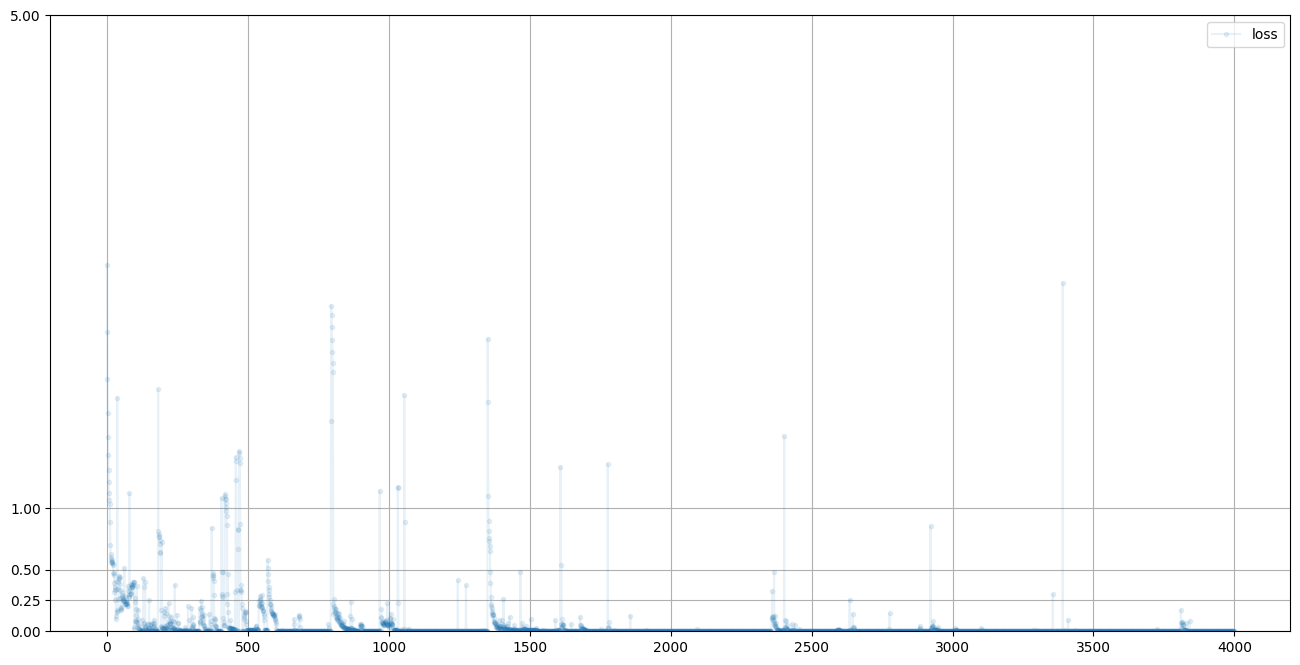

In [15]:
D.plot_progress()

### 생성기
- 레이어
  - 입력크기는 100, 히든 노드의 수는 3 * 10 * 10으로 설정

In [17]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        # 신경망 모델
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            nn.LayerNorm(3*10*10),
            nn.Linear(3*10*10, 3*218*178),
            nn.Sigmoid(),
            View((218,178,3))
        )

        # 옵티마이저 설정
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0;
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)


    def train(self, D, inputs, targets):
        # 생성기 출력 계산
        g_outputs = self.forward(inputs)

        # 생성기 출력값을 판별기로 전달
        d_outputs = D.forward(g_outputs)

        # 오차 계산
        loss = D.loss_function(d_outputs, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())

        # 기울기 초기화, 역전파, 가중치 갱신
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


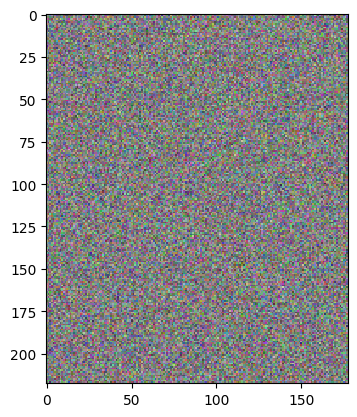

In [18]:
G = Generator()
G.to(device) # GPU

output = G.forward(generate_random_seed(100))

img = output.detach().cpu().numpy()

plt.imshow(img, interpolation='none', cmap='Blues')

In [26]:
%%time

D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

epochs = 5

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train
  for image_data_tensor in celeba_dataset:
    # 판별기 훈련
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

    # 생성기 훈련
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
epoch =  2
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
c

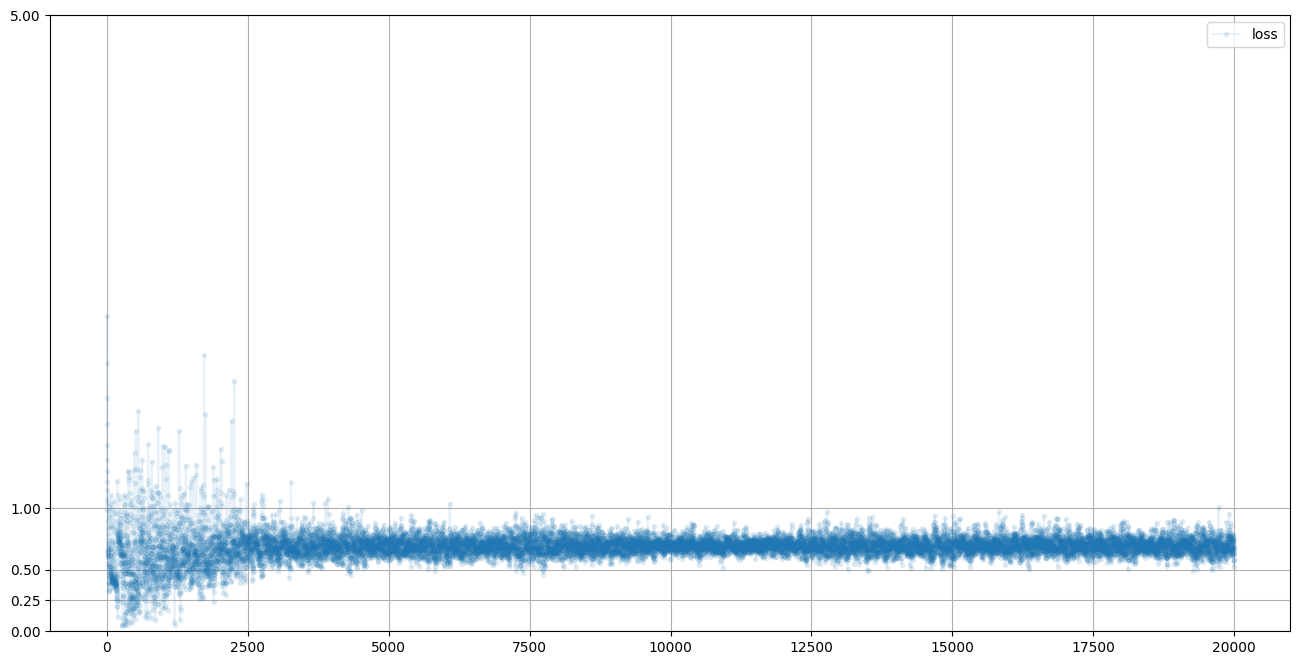

In [27]:
D.plot_progress()

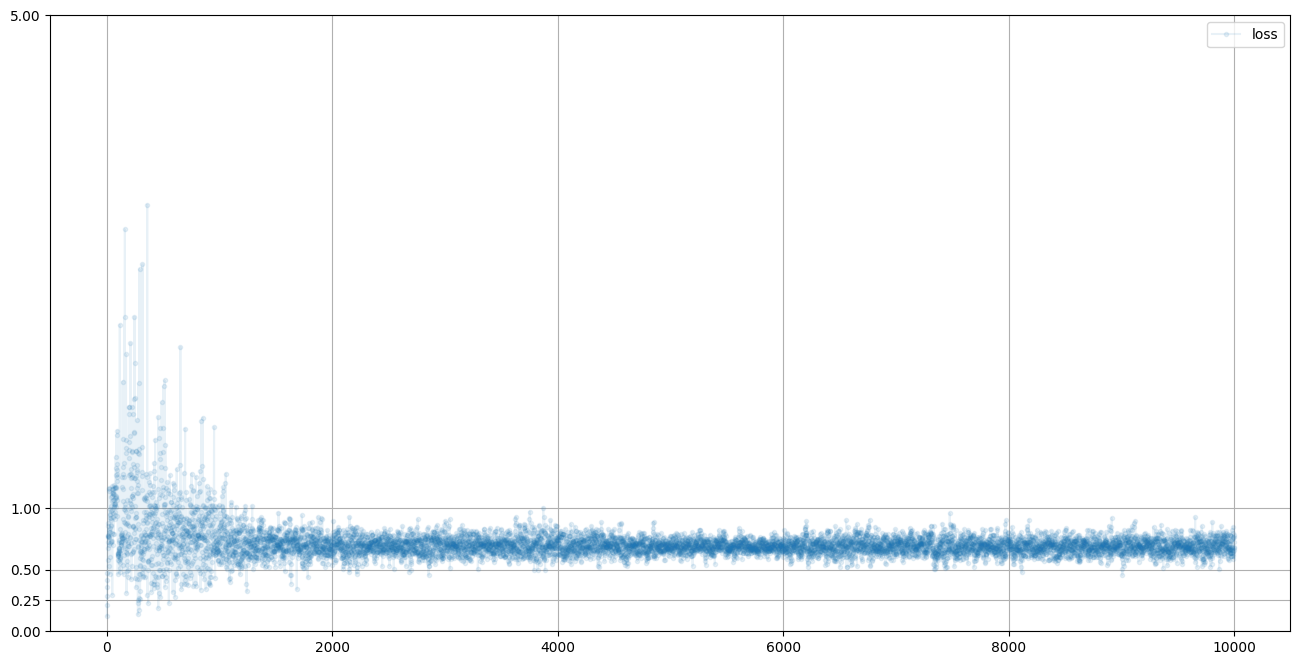

In [28]:
G.plot_progress()

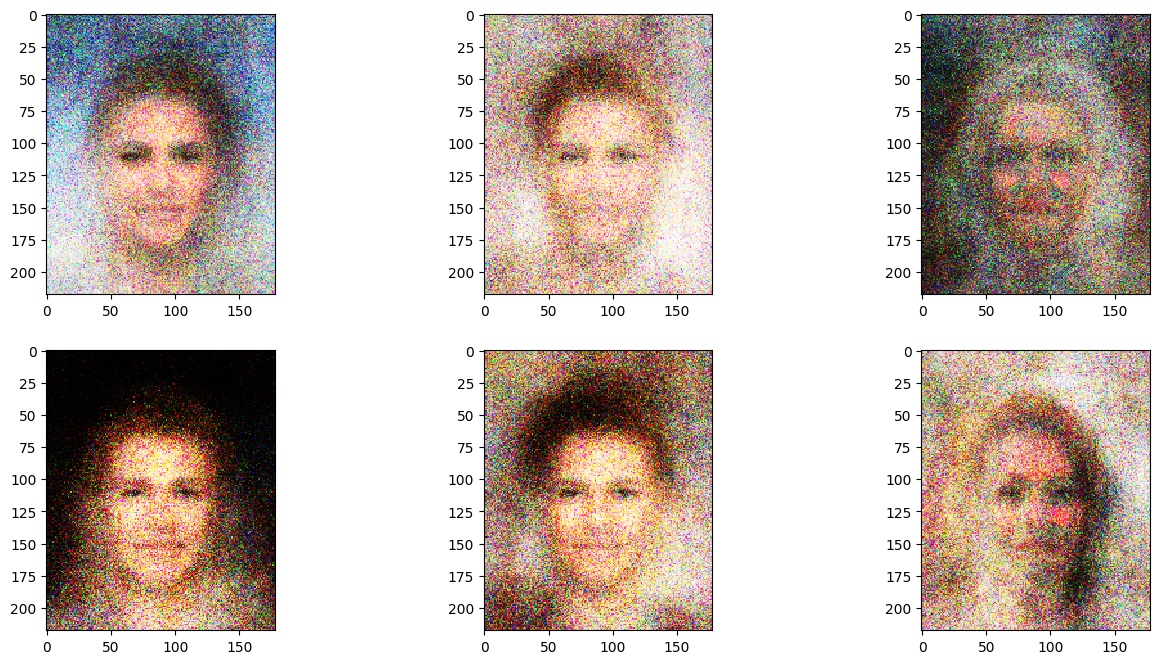

In [29]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')


In [30]:
torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.8897795677185059

In [31]:
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

1.679110050201416

In [32]:
print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    911 MiB |   1719 MiB |  77330 GiB |  77330 GiB |
|---------------------------------------------------------------------------|
| Active memory         |    911 MiB |   1719 MiB |  77330 GiB |  77330 GiB |
|---------------------------------------------------------------------------|
| Requested memory      |    907 MiB |   1711 MiB |  77093 GiB |  77092 GiB |
|---------------------------------------------------------------